In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/jiscecseaiml/fish-classification-dataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/jiscecseaiml/fish-classification-dataset


100%|██████████| 9.26G/9.26G [09:20<00:00, 17.8MB/s]


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/fish-classification-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/fish-classification-dataset/Training/Fresh_Gills/IMG_2200.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_1210.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_2027.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_2298.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_1286.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_2247.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_2205.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_1227.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_2217.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_1248.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_1112.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_1123.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_1225.JPG
/content/fish-classification-dataset/Training/Fresh_Gills/IMG_1118.JPG
/conte

In [4]:
import os
import gc
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
train_dir = "/content/fish-classification-dataset/Training"
test_dir = "/content/fish-classification-dataset/Testing"

# Data Preparation
train_Fresh_Eyes = []
train_Nonfresh_Eyes = []
for i in os.listdir(train_dir):
    if 'Fresh_Eyes' in ("/content/fish-classification-dataset/Training/{}".format(i)):

        train_Fresh_Eyes.append(("/content/fish-classification-dataset/Training/{}".format(i)))
    else:
        train_Nonfresh_Eyes.append(("/content/fish-classification-dataset/Training".format(i)))

# Concatenate and shuffle
train_imgs = train_Nonfresh_Eyes + train_Fresh_Eyes
random.shuffle(train_imgs)
del train_Nonfresh_Eyes, train_Fresh_Eyes
gc.collect()

# Display sample images
for directory_path in train_imgs[0:3]:
    files = os.listdir(directory_path)
    for file_name in files[0:3]:
        file_path = os.path.join(directory_path, file_name)
        if os.path.isfile(file_path):
            img = mpimg.imread(file_path)
            plt.imshow(img)
            plt.show()

# Define constants
batch_size = 32
epochs = 20

image_height = 128
image_width = 128

# Create data generators
train_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical')

# Build the hybrid CNN-LSTM model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    # Reshape for LSTM input: (batch_size, time_steps, features)
    tf.keras.layers.Reshape((1, 128)),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,

    validation_steps=test_generator.samples // batch_size)

# Save the model
model.save('hybrid_cnn_lstm_model.h5')

# Visualize training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get true labels and predictions

test_generator.reset()
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Precision, Recall, F1-Score
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred)

x = np.arange(len(class_labels))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, fscore, width, label='F1-score')
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Class-wise Performance Metrics')
plt.xticks(x, class_labels, rotation=45)
plt.legend()
plt.show()

# Sample predictions visualization
sample_images, sample_labels = next(test_generator)
sample_predictions = model.predict(sample_images)
sample_preds = np.argmax(sample_predictions, axis=1)

plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {class_labels[sample_labels[i].argmax()]}\nPredicted: {class_labels[sample_preds[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [7]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=ef7d4b62310cc45f7559af7f257f1d25d33787e171379e5592f2ea70912c74f4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


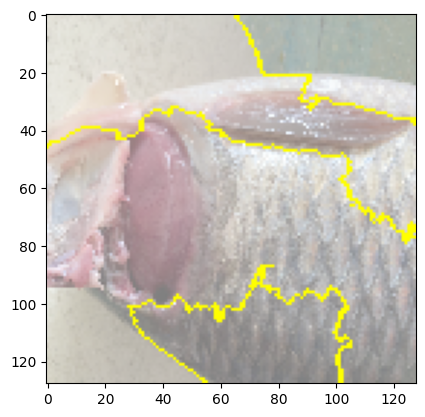

In [8]:
import lime
import lime.lime_image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from skimage.segmentation import mark_boundaries

# Load the trained model
model = tf.keras.models.load_model('hybrid_cnn_lstm_model.h5')

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale the image
    return img_array

# Define function to predict with your model
def predict_fn(images):
    return model.predict(images)

# LIME explanation for a single image prediction
def explain_prediction(img_array):
    """
    This function takes an image array and explains the model's prediction using LIME.

    Args:
        img_array: A NumPy array representing the image to be explained.

    Returns:
        A LIME explanation object containing the explanation for the image.
    """
    explainer = lime.lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_array[0], predict_fn, top_labels=5, hide_color=0, num_samples=1000)
    return explanation

# Example usage: Explain the prediction for the first image in your test set
img_path = '/content/fish-classification-dataset/Testing/Nonfresh_Gills/IMG_7440.JPG'  # Update with a valid path
img_array = preprocess_image(img_path, target_size=(128, 128))
explanation = explain_prediction(img_array)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()